In [1]:
import sys
sys.path.append('../') 


%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [2]:
aggregate_by_state = False
outcome_type = 'deaths'

# Dataset Creation

In [3]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
# df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'Respiratory Mortality',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

loaded and merged COVID-19 cases/deaths data successfully


In [4]:
from datetime import date

In [5]:
first_date = date(2020,1,22)
first_ordinal = first_date.toordinal()

 Create:

df['days_since_order'] which is the number of days since the shelter in place order has gone into effect

df['week_since_order'] which is if it's been a week since the order

df['two_weeks_since_order'] which is if it's been two weeks since the order

In [6]:
days_since_order = []
past_one_week = []
past_two_weeks = []
shelter_in_place_orders = list(df['stay at home'])
nan_counties = []
total_num_days = len(list(df['deaths'])[0])
for j,order in enumerate(shelter_in_place_orders):
    county_days_since_orders = []
    county_one_week = []
    county_two_week = []
    if np.isnan(order):
        nan_counties.append(list(df['CountyName'])[j]+ ' '+list(df['StateName'])[j])
        order = 1e10
    for i in range(total_num_days):
        current_date = first_ordinal+i
        county_days_since_orders.append(max(current_date-order,0))
        county_one_week.append(int(current_date > order + 7))
        county_two_week.append(int(current_date > order + 14))

    days_since_order.append(county_days_since_orders)
    past_one_week.append(county_one_week)
    past_two_weeks.append(county_two_week)

df['days_since_order'] = days_since_order
df['week_since_order'] = past_one_week
df['two_weeks_since_order'] = past_two_weeks



Find neighboring county deaths/cases

In [7]:
neighboring_counties_df = pd.read_csv('../data/county_level/raw/county_ids/county_adjacency2010.csv')

In [8]:
df['countyFIPS'] = [int(v) for v in list(df['countyFIPS'])]

In [9]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
number_of_days = len(list(df['deaths'])[0])
for fips in county_fips:
    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    

    sum_neighboring_county_deaths = np.zeros(number_of_days)
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(number_of_days)
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)



In [10]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


Find the number of new deaths (smoothed)

In [11]:
new_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:
    county_new_deaths = []
    for i in range(len(list(county_deaths))):
        if i == 0: 
            county_new_deaths.append(list(county_deaths)[0])
        else:
            county_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-1])

    smoothed_county_new_deaths = []
    window = 5
    for i in range(len(county_new_deaths)):
        start = max(i-window,0)
        end = min(i+window,len(county_new_deaths)-1)
        smoothed_county_new_deaths.append(sum(county_new_deaths[start:end])/len(county_new_deaths[start:end]))
        
    new_deaths.append(np.array(smoothed_county_new_deaths))
df['new_deaths'] = new_deaths

Find number of new deaths per capita * 100k

In [12]:
new_deaths = []
per_cap_deaths = []
deaths = list(df['deaths'])
pop = list(df['PopulationEstimate2018'])
for county_ind,county_deaths in enumerate(deaths):
    county_per_cap_deaths = []
    for i in range(len(list(county_deaths))):
        county_per_cap_deaths.append(list(county_deaths)[i]/pop[county_ind]*100000)
        
    per_cap_deaths.append(np.array(county_per_cap_deaths))
    
df['deaths_per_cap'] = per_cap_deaths

Find number of new cases per capita * 100k


In [13]:
new_deaths = []
per_cap_deaths = []
deaths = list(df['cases'])
pop = list(df['PopulationEstimate2018'])
for county_ind,county_deaths in enumerate(deaths):
    county_per_cap_deaths = []
    for i in range(len(list(county_deaths))):
        county_per_cap_deaths.append(list(county_deaths)[i]/pop[county_ind]*100000)
        
    per_cap_deaths.append(np.array(county_per_cap_deaths))
    
df['cases_per_cap'] = per_cap_deaths

In [14]:
max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-1])
    
df['max_death_per_cap'] = max_deaths_per_cap

per_cap_deaths = list(df['deaths_per_cap'])
max_deaths_per_cap = []

for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14])
    
df['max_death_per_cap_minus_2_weeks'] = max_deaths_per_cap

max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-19])
    
df['max_death_per_cap_minus_2_weeks_5_day_growth'] = max_deaths_per_cap


max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-21])
    
df['max_death_per_cap_minus_2_weeks_7_day_growth'] = max_deaths_per_cap



max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-17])
    
df['max_death_per_cap_minus_2_weeks_3_day_growth'] = max_deaths_per_cap



max_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:    
    max_deaths.append( county_deaths[-14])
    
df['max_deaths_minus_two_weeks'] = max_deaths


max_deaths = []
deaths = list(df['cases'])
for county_deaths in deaths:    
    max_deaths.append( county_deaths[-14])
    
df['max_cases_minus_two_weeks'] = max_deaths

Only include rural counties

In [39]:
df = df.loc[df['Rural-UrbanContinuumCode2013'] > 3]

## Find neighbors

In [40]:
for c in df.columns:
    if '#' in c:
        print(c)

#EligibleforMedicare2018
#FTEHospitalTotal2017
#HospParticipatinginNetwork2017
#Hospitals
#ICU_beds
#Cases_01-22-2020
#Cases_01-23-2020
#Cases_01-24-2020
#Cases_01-25-2020
#Cases_01-26-2020
#Cases_01-27-2020
#Cases_01-28-2020
#Cases_01-29-2020
#Cases_01-30-2020
#Cases_01-31-2020
#Cases_02-01-2020
#Cases_02-02-2020
#Cases_02-03-2020
#Cases_02-04-2020
#Cases_02-05-2020
#Cases_02-06-2020
#Cases_02-07-2020
#Cases_02-08-2020
#Cases_02-09-2020
#Cases_02-10-2020
#Cases_02-11-2020
#Cases_02-12-2020
#Cases_02-13-2020
#Cases_02-14-2020
#Cases_02-15-2020
#Cases_02-16-2020
#Cases_02-17-2020
#Cases_02-18-2020
#Cases_02-19-2020
#Cases_02-20-2020
#Cases_02-21-2020
#Cases_02-22-2020
#Cases_02-23-2020
#Cases_02-24-2020
#Cases_02-25-2020
#Cases_02-26-2020
#Cases_02-27-2020
#Cases_02-28-2020
#Cases_02-29-2020
#Cases_03-01-2020
#Cases_03-02-2020
#Cases_03-03-2020
#Cases_03-04-2020
#Cases_03-05-2020
#Cases_03-06-2020
#Cases_03-07-2020
#Cases_03-08-2020
#Cases_03-09-2020
#Cases_03-10-2020
#Cases_03-11-2020


In [87]:
# Features for finding neighbors
very_important_vars = [
#     'PopulationDensityperSqMile2010',
#     'PopulationEstimate2018',
#     'Rural-UrbanContinuumCode2013',
#      'MedianAge2010',
#     'stay at home',
#
#         '#ICU_beds',

    'max_death_per_cap_minus_2_weeks_5_day_growth',
      'max_death_per_cap_minus_2_weeks_3_day_growth',
          'max_death_per_cap_minus_2_weeks_7_day_growth',
#         'max_death_per_cap_minus_2_weeks',
#         'max_deaths_minus_two_weeks',
#         'max_cases_minus_two_weeks'

]

# static_features = [ 
#     'PopulationDensityperSqMile2010',
#     'PopulationEstimate2018',
#     'Rural-UrbanContinuumCode2013',
#      'MedianAge2010',
#     'stay at home'
# ]
# very_important_vars = static_features

sort by deaths two weeks ago, scale (and potentially do PCA) 

In [88]:
# very_important_vars = static_features

In [91]:
from sklearn.preprocessing import StandardScaler
from scipy import spatial
df = df.sort_values('max_deaths_minus_two_weeks', ascending=False)

covariates = df[very_important_vars]

covariates_clean = covariates.dropna(1)


numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_covs = covariates_clean.select_dtypes(include=numerics)


scaled_covariates = StandardScaler().fit_transform(numeric_covs.values)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principle_components = pca.fit_transform(scaled_covariates)
# principle_components = scaled_covariates
tree = spatial.KDTree(principle_components)

In [92]:
def find_top_k_time_dynamic(county_index,time_query,df,num_neighbors,tol=.1):
    death_per_cap = list(df['deaths_per_cap'])
    print('============')
    print(county_index)
    print(time_query)
    query_val = death_per_cap[county_index][time_query]
    possible_indices = []
    time_indices = []
    for i in range(len(death_per_cap)):

        dists = np.abs(death_per_cap[i][:time_query+1]-query_val)
        best_match = death_per_cap[i][np.argmin(dists)]
        time_index = np.argmin(dists)
        if i == county_index:
            time_index = len(dists)-1
            best_match = death_per_cap[i][time_index]
            
        assert time_index < len(death_per_cap[i])-time_query, time_index
        if best_match < query_val*(1+tol) and best_match > query_val*(1-tol):
            possible_indices.append(i)
            time_indices.append(time_index)
       
    index_to_time_dict = {k:v for (k,v) in zip(possible_indices,time_indices)}
#     print(list(zip(possible_indices,time_indices)))
    most_similar_neighbors, distances = find_top_k_matches(county_index,1500)
    
    final_matches = []
    final_times = []
    final_distances = []

    for i in range(len(most_similar_neighbors)):
        if most_similar_neighbors[i] in possible_indices:
            final_matches.append(most_similar_neighbors[i])
            final_distances.append(distances[i])
            final_times.append(index_to_time_dict[most_similar_neighbors[i]])
            if len(final_matches) == num_neighbors:
                break

    return final_matches, final_times, final_distances
            

    
        
    
    
    

In [99]:
# Finds top k nearest neighbors
def find_top_k_matches(county_index,num_neighbors):
    query_vector = principle_components[county_index]
    neighbors = tree.query(query_vector,num_neighbors)
    neighbor_indices = list(neighbors[1])
    distances = list(neighbors[0])
    return neighbor_indices, distances
  

def find_time_match(query_county_index,match_county_index,query_county_date,outcome='per_cap_deaths'):
    query_val = list(df[outcome])[query_county_index][query_county_date]
    
    dists = np.abs(list(df[outcome])[match_county_index][:query_county_date]-query_val)
    time_index = np.argmin(dists)
    return time_index

    
                
            

In [100]:
find_top_k_time_dynamic(5,-14,df,5)


5
-14


([5, 21, 83, 0, 289],
 [81, 78, 77, 77, 76],
 [0.0,
  0.8821275779065932,
  1.5596260447470531,
  2.700672245741885,
  2.9201579345881217])


## Create Baseline

In [101]:
outcome_type = 'deaths_per_cap'
import fit_and_predict
advanced_model = {'model_type':'advanced_shared_model'}
linear = {'model_type':'linear'}
d = 14
df = fit_and_predict.fit_and_predict_ensemble(df, 
                                              target_day=np.array(range(1, d+1)),
                                              mode='eval_mode',
                                              outcome=outcome_type,
                                              methods=[ 
                                                  advanced_model,
                                                      linear
                                                     ],
                                              output_key='predicted_al',
                                              verbose=True
                                             )



KeyboardInterrupt: 

# 

In [ ]:
# df['predicted_al']

### Graph Visualizations

In [102]:
outcome_type = 'deaths_per_cap'

# outcome_type = 'cases_per_cap'
# outcome_type = 'deaths'

In [103]:
# def plot_matched_counties(df,indices,time_dif = False, plot_preds = False):
#     """
#     Plots model predictions vs actual
#     row: dataframe row
#     window: autoregressive window size
#     """
#     outcome = outcome_type
    
#     if time_dif:
#         time_inds = []
#         for ind in indices:
#             t = find_time_match(indices[0],ind,-14,outcome=outcome)
#             time_inds.append(t)
    
    
#     outcomes = list(df[outcome_type])
#     counties = list(df['CountyName'])
#     states = list(df['StateName'])
#     if time_dif:
#         print(time_inds)
#     for i in range(len(indices)):
# #         county_vals = outcomes[indices[i]][times[i]:]
#         if time_dif:
#             print(len(outcomes[indices[i]][time_inds[i]:]))
#             print('-----------------=============-----------')
#             county_vals = outcomes[indices[i]][time_inds[i]:]
#         else:
#             county_vals = outcomes[indices[i]][-14:]
#         sns.lineplot(list(range(len(county_vals))),county_vals, label=counties[indices[i]]+' '+states[indices[i]])

#     avg_neighbors = np.array(len(ounty_vals = outcomes[indices[0]][time_inds[0]:]))
#     for i in range(1,len(indices)):
        
#         county_vals = outcomes[indices[i]][time_inds[i]:]
#         avg_neighbors += county_vals[:len(avg_neighbors)]
#     avg_neighbors = avg_neighbors/(len(indices)-1)
#     sns.lineplot(list(range(len(avg_neighbors))),avg_neighbors, label='avg neighbor')
    

        
#     if plot_preds:
#         preds = list(df['predicted_al'])[indices[0]]

#         sns.scatterplot(list(range(len(county_vals)))[-len(preds):],preds,label='pred')

#     plt.ylabel(outcome_type)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.figure(dpi=500)    
#     plt.show()
    
#     total_difs = 0
#     for t in range(1,15):
#         vals = []
#         for i in range(len(indices)):
#             vals.append(outcomes[indices[i]][-t])
#         avg_val = np.mean(vals)
#         val_difs = np.sum([np.abs(v-avg_val) for v in vals])
#         total_difs += val_difs
#     pred_difs = 0 
    
#     if plot_preds:
#         for t in range(1,15):
#              pred_difs += np.abs(preds[-t] - outcomes[indices[0]][-t])
#     if not plot_preds:
#         pred_difs = 0
#     return total_difs, pred_difs
             

In [104]:
def plot_dynamic_matched_counties(df,indices,time_dif = False, plot_preds = False, weighted = False):
    """
    Plots model predictions   vs actual
    row: dataframe row
    window: autoregressive window size
    """
    index = indices[0]
    
    outcomes = list(df[outcome_type])
    counties = list(df['CountyName'])
    states = list(df['StateName'])


    county_indices, time_indices, distances = find_top_k_time_dynamic(index,-14,df,5,tol=.1)
    if len(county_indices) == 1:
        print('no match found for county: '+ counties[county_indices[0]])
        return None, None
    print(len(county_indices))
    for i in range(len(county_indices)):

        
        county_vals = outcomes[county_indices[i]][time_indices[i]:]
        if i == 0:
            sns.lineplot(list(range(len(county_vals))),county_vals, label=counties[county_indices[i]]+' '+states[county_indices[i]],linewidth=4.0)
        else:
     
            sns.lineplot(list(range(len(county_vals))),county_vals, label=counties[county_indices[i]]+' '+states[county_indices[i]])


    avg_neighbors = np.zeros(len(outcomes[county_indices[0]][time_indices[0]:]))
    denom = 0
    for i in range(1,len(county_indices)):
        county_vals = outcomes[county_indices[i]][time_indices[i]:]
        if weighted:
            avg_neighbors += 1/(distances[i])*county_vals[:len(avg_neighbors)]
            denom += 1/(distances[i])
        else:
            avg_neighbors += county_vals[:len(avg_neighbors)]
    
    if weighted:
        avg_neighbors = avg_neighbors/denom
    else:
        avg_neighbors = avg_neighbors/(len(county_indices)-1)
    
    sns.lineplot(list(range(len(avg_neighbors))),avg_neighbors, label='avg neighbor',linewidth=4.0)
    

    if plot_preds:
         
        county_vals = outcomes[county_indices[0]][time_indices[0]:]
        preds = list(df['predicted_al'])[county_indices[0]]

        sns.scatterplot(list(range(len(county_vals)))[-len(preds):],preds,label='pred')

        
    

    plt.ylabel(outcome_type)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()
    
    total_difs = 0
    for t in range(1,15):
        vals = []
        for i in range(len(indices)):
            vals.append(outcomes[indices[i]][-t])
        avg_val = np.mean(vals)
        val_difs = np.sum([np.abs(v-avg_val) for v in vals])
        total_difs += val_difs
    pred_difs = 0 
    
    truth = outcomes[county_indices[0]][time_indices[0]:]
    avg_diff = 0
    for i in range(len(avg_neighbors)):
        avg_diff += np.abs(avg_neighbors[i]-truth[i])
        
        
        
    if plot_preds:
        for t in range(1,15):
             pred_difs += np.abs(preds[-t] - outcomes[indices[0]][-t])
    if not plot_preds:
        pred_difs = 0
    total_difs = avg_diff
    return total_difs, pred_difs
             

0
-14
3


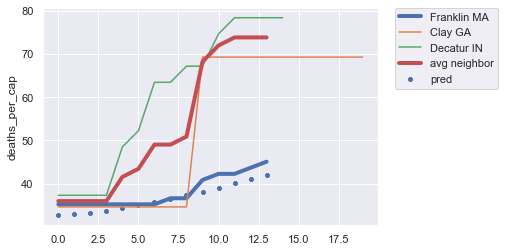

<Figure size 3000x2000 with 0 Axes>

1
-14
5


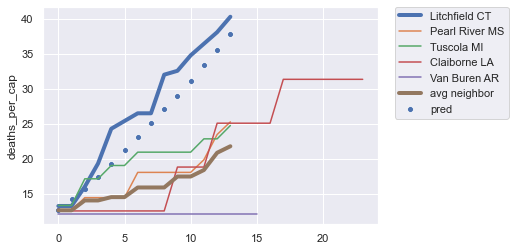

<Figure size 3000x2000 with 0 Axes>

2
-14
4


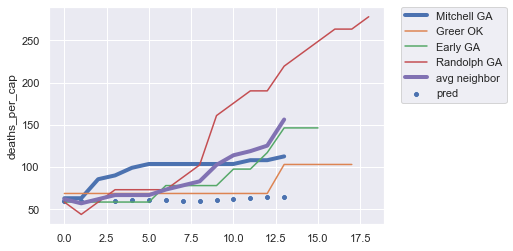

<Figure size 3000x2000 with 0 Axes>

3
-14
5


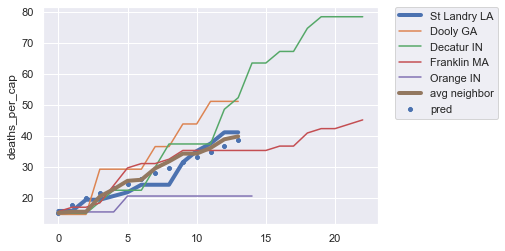

<Figure size 3000x2000 with 0 Axes>

4
-14
3


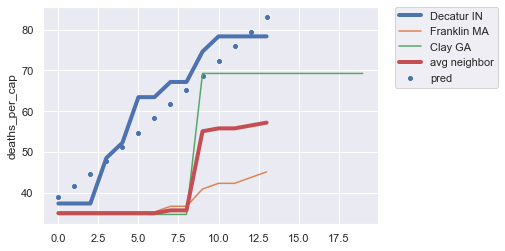

<Figure size 3000x2000 with 0 Axes>

5
-14
5


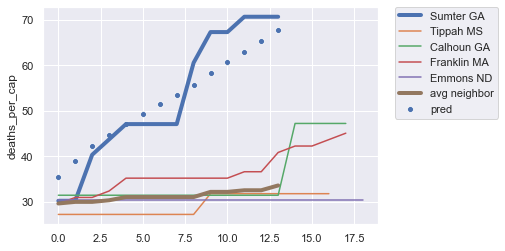

<Figure size 3000x2000 with 0 Axes>

6
-14
5


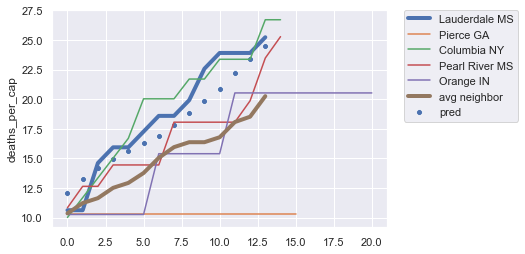

<Figure size 3000x2000 with 0 Axes>

7
-14
3


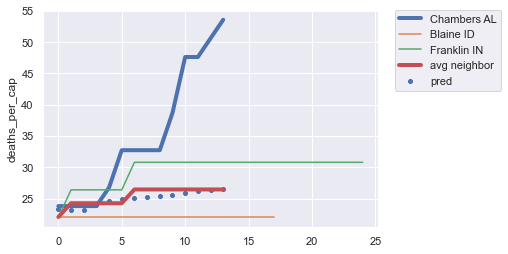

<Figure size 3000x2000 with 0 Axes>

8
-14
5


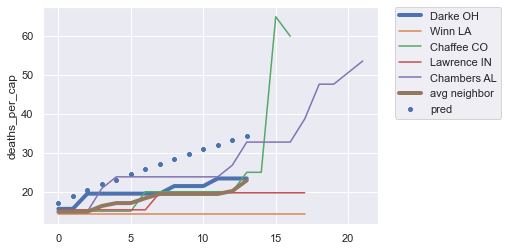

<Figure size 3000x2000 with 0 Axes>

9
-14
2


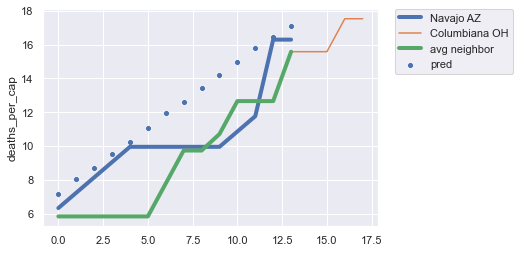

<Figure size 3000x2000 with 0 Axes>

10
-14
3


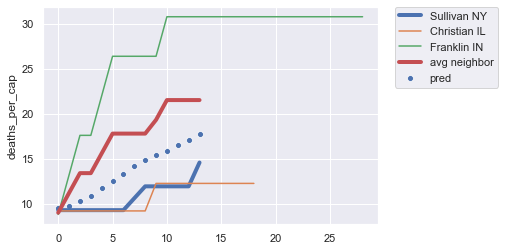

<Figure size 3000x2000 with 0 Axes>

11
-14
4


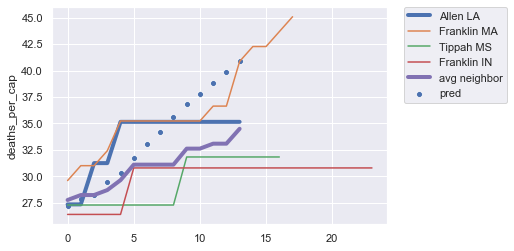

<Figure size 3000x2000 with 0 Axes>

12
-14
5


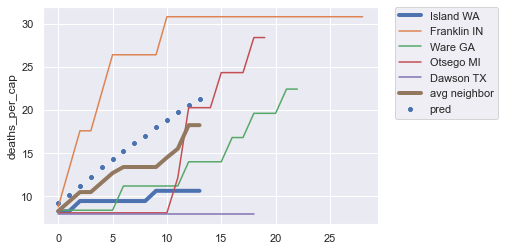

<Figure size 3000x2000 with 0 Axes>

13
-14
5


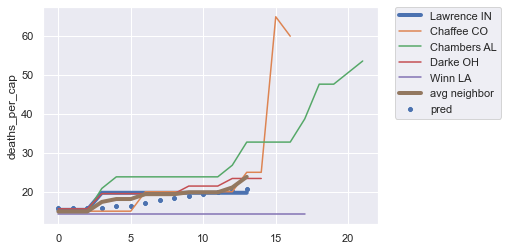

<Figure size 3000x2000 with 0 Axes>

14
-14
5


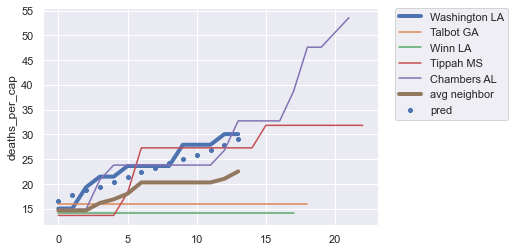

<Figure size 3000x2000 with 0 Axes>

15
-14
5


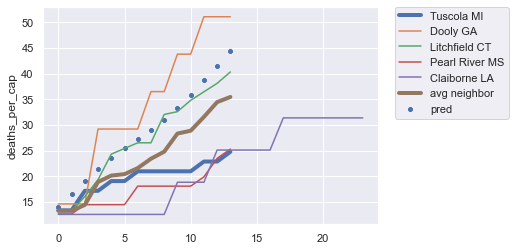

<Figure size 3000x2000 with 0 Axes>

16
-14
no match found for county: Franklin
17
-14
5


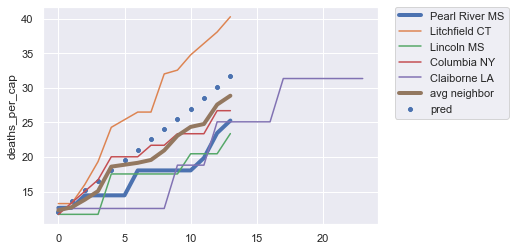

<Figure size 3000x2000 with 0 Axes>

18
-14
5


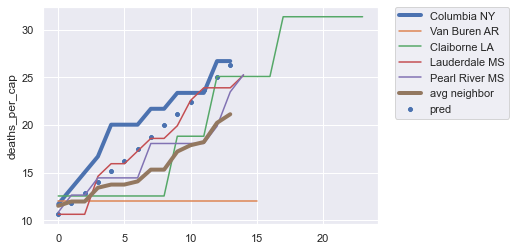

<Figure size 3000x2000 with 0 Axes>

19
-14
5


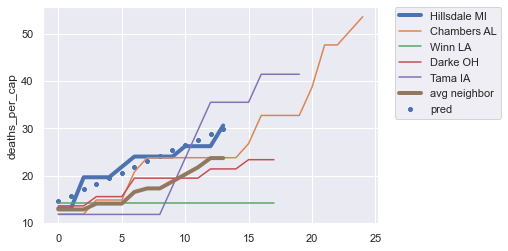

<Figure size 3000x2000 with 0 Axes>

total dif
1989.1789707403195
pred dif
1422.8520218905367


In [105]:
total_difs = 0
pred_difs = 0
for i in range(0,20):
    neigh_indices = [i] 

#     val_difs, pred_dif = plot_matched_counties(df,neigh_indices,time_dif=True)
    val_difs, pred_dif = plot_dynamic_matched_counties(df,neigh_indices,time_dif=True,plot_preds=True,weighted=False)
    
    if val_difs is not None:

        total_difs += val_difs
        pred_difs += pred_dif
    
print('total dif')
print(total_difs)
print('pred dif')
print(pred_difs)

In [68]:
df

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,max_death_per_cap,max_death_per_cap_minus_2_weeks,max_death_per_cap_minus_2_weeks_5_day_growth,max_death_per_cap_minus_2_weeks_7_day_growth,max_death_per_cap_minus_2_weeks_3_day_growth,max_deaths_minus_two_weeks,max_cases_minus_two_weeks,y_preds_0,y_preds_1,predicted_al
1214,25011,25.0,11.0,Franklin,MA,Massachusetts,42.583106,-72.591410,42.578289,-72.558703,...,45.093922,35.229627,11.273481,18.319406,4.227555,25,143,"[31.95256024682155, 31.467412318388707, 30.718...","[33.11584910446288, 33.961360145427896, 34.806...","[32.667899490533046, 33.001011424690965, 33.23..."
304,9005,9.0,5.0,Litchfield,CT,Connecticut,41.795942,-73.251505,41.727851,-73.187494,...,40.306773,13.251542,8.282214,9.938656,6.073623,24,403,"[13.057087123777807, 14.765579106560795, 16.20...","[12.147246716102273, 13.638045176714826, 15.12...","[12.612235347763065, 14.214289598008065, 15.68..."
480,13205,13.0,205.0,Mitchell,GA,Georgia,31.212189,-84.213203,31.216853,-84.172094,...,112.653208,63.085797,13.518385,58.579668,4.506128,14,138,"[58.79042319482317, 58.69165343969683, 58.6595...","[60.832732516222045, 62.18457101658254, 63.536...","[59.529105999204575, 59.955006705596716, 60.42..."
1153,22097,22.0,97.0,St Landry,LA,Louisiana,30.603294,-92.003297,30.514029,-92.111314,...,41.080663,15.707312,10.874293,10.874293,10.874293,13,113,"[15.672107502495278, 17.96401789207119, 19.822...","[14.499057561258514, 17.278043593833065, 20.05...","[15.164023862145081, 17.66690154059852, 19.924..."
704,18031,18.0,31.0,Decatur,IN,Indiana,39.304223,-85.506422,39.319975,-85.494211,...,78.375756,37.321788,14.928715,22.393073,14.928715,10,127,"[34.675206135347445, 32.773215829037625, 31.62...","[41.05396730611329, 46.279017690527716, 51.504...","[38.83263602540106, 41.57577526729282, 44.5822..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2290,2.0,290.0,Yukon-Koyukuk,AK,NaN,NaN,NaN,65.010262,-152.550423,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,"[1.4103536217025587, 3.064161063360857, 4.8606...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06158985619972761, 0.13381129126848204, 0.2..."
89,2282,2.0,282.0,Yakutat,AK,NaN,NaN,NaN,59.547975,-139.724878,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,"[1.6687187821518252, 4.006541344758106, 7.0238...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03411946357321171, 0.08191975959590019, 0.1..."
2965,53043,53.0,43.0,Lincoln,WA,Washington,47.572817,-118.415509,47.633857,-118.325118,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,"[1.4249215405625502, 3.11022810274805, 5.14863...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07477576100921321, 0.16321577481621177, 0.2..."
37,1075,1.0,75.0,Lamar,AL,Alabama,33.781704,-88.097957,33.762769,-88.109649,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,8,"[1.3962831804056337, 3.0145430172000443, 4.760...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06849863630389702, 0.14788696781239624, 0.2..."


In [106]:
len(df)

1975

In [33]:
from collections import Counter

In [82]:
rural_codes = list(df['Rural-UrbanContinuumCode2013'])
deaths = list(df['deaths'])
rural_counties = Counter({i:deaths[i][-14] for i in range(len(df)) if rural_codes[i] > 3})
rural_counties = [r[0] for r in rural_counties.most_common()]


In [84]:
for r in rural_counties:
    print(df.iloc[r]['deaths'][-14])
    print(deaths[r][-14])

25
25
24
24
14
14
13
13
10
10
9
9
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
-14
4


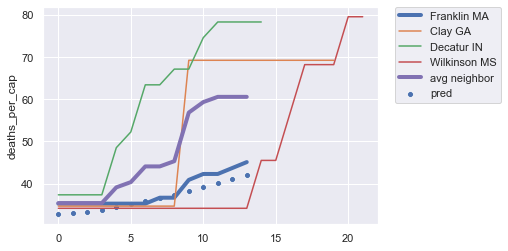

<Figure size 3000x2000 with 0 Axes>

1
-14
5


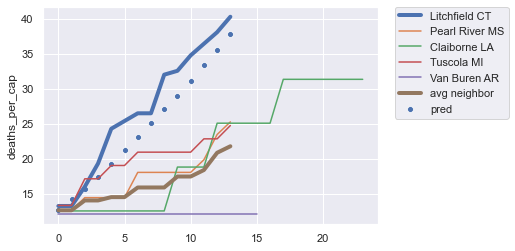

<Figure size 3000x2000 with 0 Axes>

2
-14
5


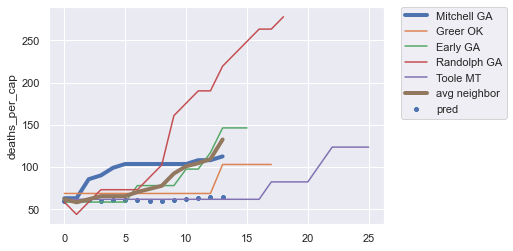

<Figure size 3000x2000 with 0 Axes>

3
-14
5


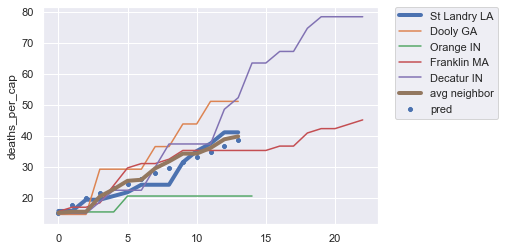

<Figure size 3000x2000 with 0 Axes>

4
-14
4


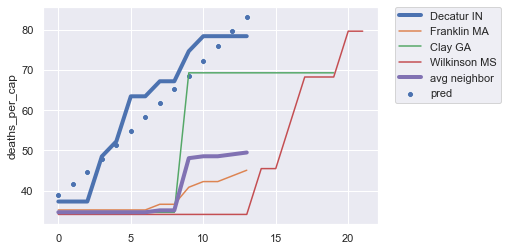

<Figure size 3000x2000 with 0 Axes>

5
-14
5


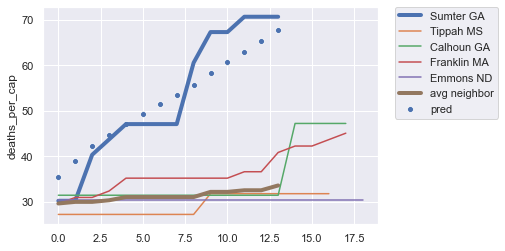

<Figure size 3000x2000 with 0 Axes>

6
-14
5


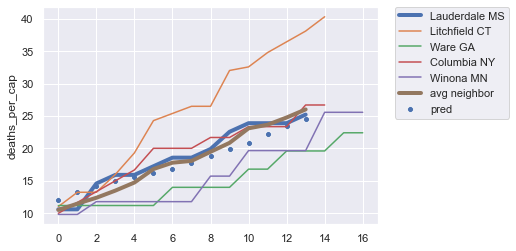

<Figure size 3000x2000 with 0 Axes>

7
-14
5


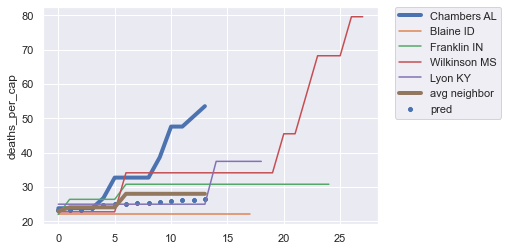

<Figure size 3000x2000 with 0 Axes>

8
-14
5


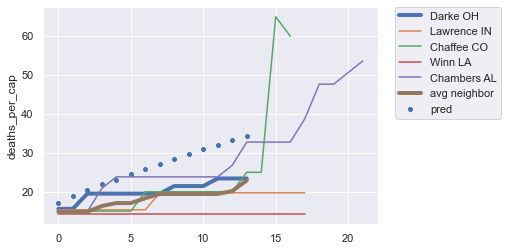

<Figure size 3000x2000 with 0 Axes>

9
-14
5


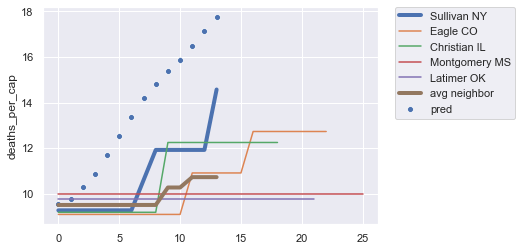

<Figure size 3000x2000 with 0 Axes>

10
-14
5


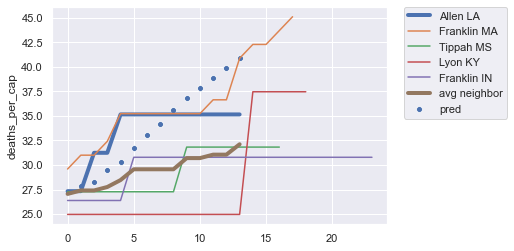

<Figure size 3000x2000 with 0 Axes>

11
-14
5


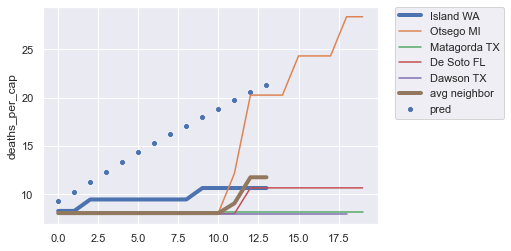

<Figure size 3000x2000 with 0 Axes>

12
-14
5


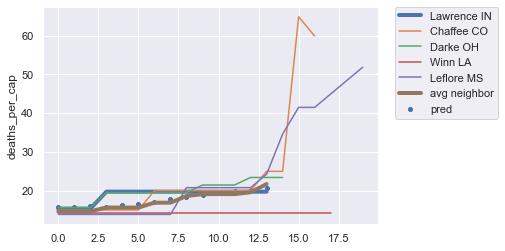

<Figure size 3000x2000 with 0 Axes>

13
-14
5


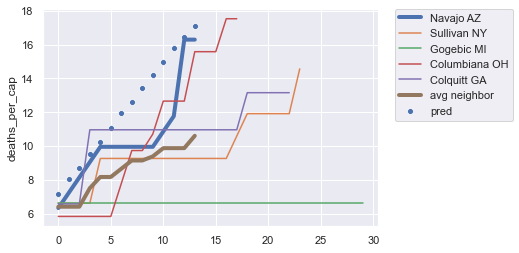

<Figure size 3000x2000 with 0 Axes>

14
-14
5


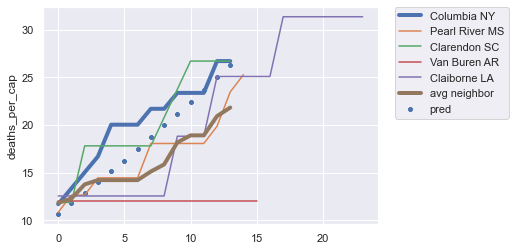

<Figure size 3000x2000 with 0 Axes>

15
-14
5


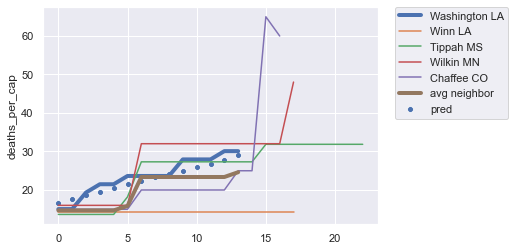

<Figure size 3000x2000 with 0 Axes>

16
-14
5


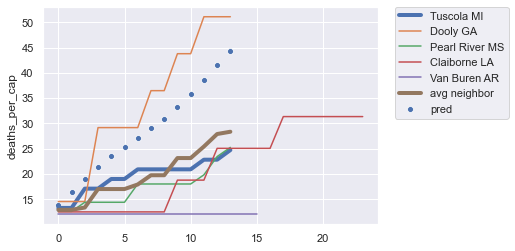

<Figure size 3000x2000 with 0 Axes>

17
-14
3


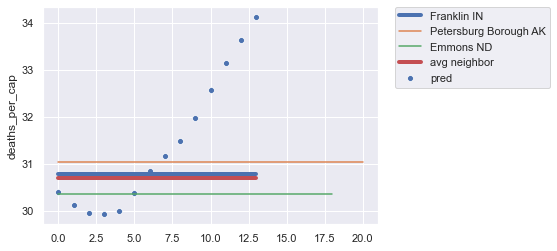

<Figure size 3000x2000 with 0 Axes>

18
-14
5


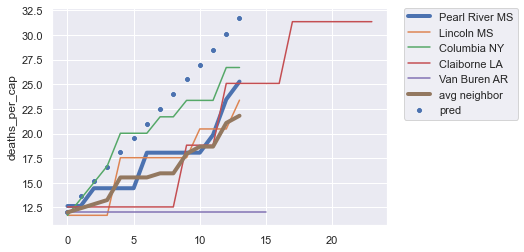

<Figure size 3000x2000 with 0 Axes>

19
-14
5


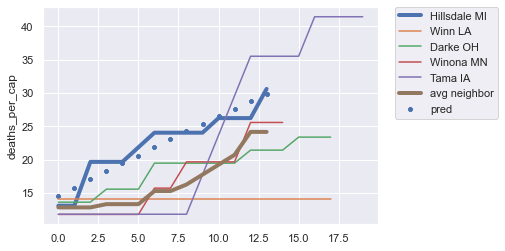

<Figure size 3000x2000 with 0 Axes>

total dif
1720.6800530720195
pred dif
1439.4266648309244


In [85]:
total_difs = 0
pred_difs = 0
for i in rural_counties[:20]:
    neigh_indices = find_top_k_matches(i,5)
    neigh_indices = [i] 

#     val_difs, pred_dif = plot_matched_counties(df,neigh_indices,time_dif=True)
    val_difs, pred_dif = plot_dynamic_matched_counties(df,neigh_indices,time_dif=True,plot_preds=True,weighted=False)

    if val_difs:
        total_difs += val_difs
        pred_difs += pred_dif
    
print('total dif')
print(total_difs)
print('pred dif')
print(pred_difs)

In [ ]:
big one: 26508.589044247
extra feats: 17280.911096252134
statics: 29542.312627359406


In [35]:
counties 0-20
cases total_dif  24518.308526995912
deaths total_dif 22761.696791437957
features total_dif 11958.136102136708


SyntaxError: invalid syntax (<ipython-input-35-1b65b7d2966e>, line 1)

In [ ]:
rural_features = 10391.618997903128
no features = 19653.958291458024
static_features = 11142.3903320078
